/tmp/ipython-input-15-1383405605.py:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('/content/energy_data.txt.txt', sep=';',
/tmp/ipython-input-15-1383405605.py:14: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/content/energy_data.txt.txt', sep=';',
/tmp/ipython-input-15-1383405605.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean().dropna()


📊 RMSE: 0.497
📊 MAE: 0.346


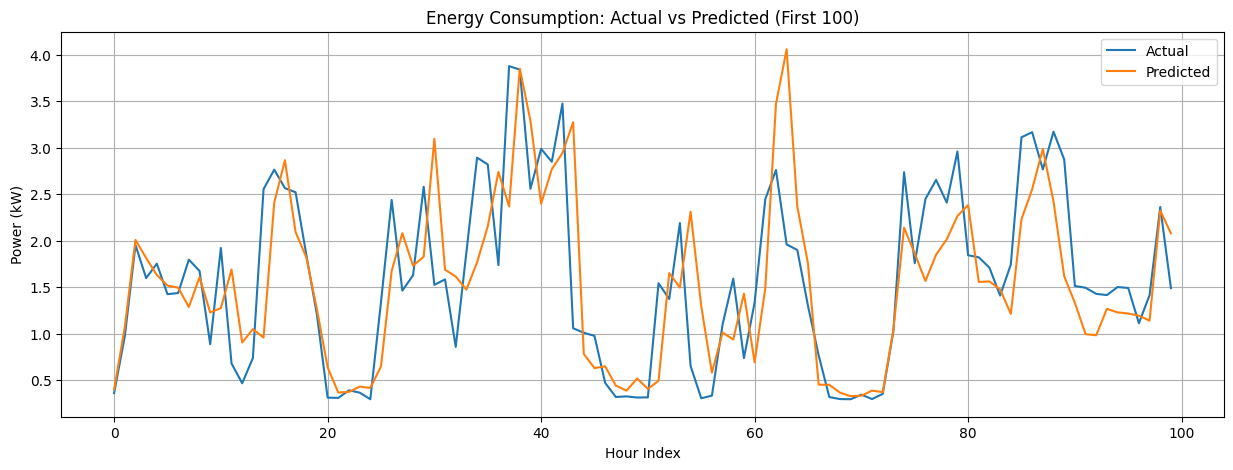

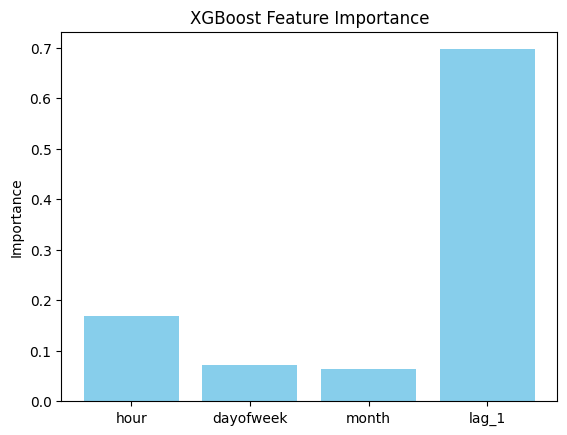

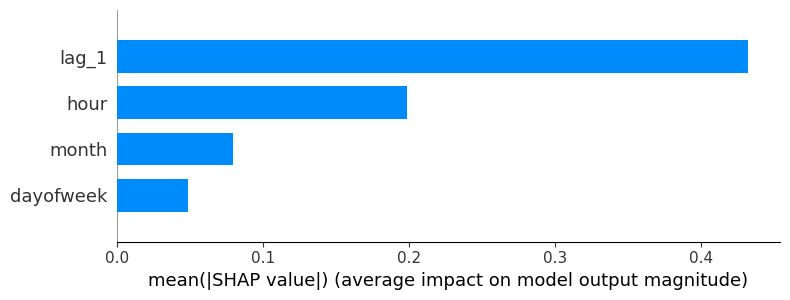

In [ ]:
# ✅ Install necessary libraries
!pip install xgboost shap --quiet

# ✅ Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import shap

# ✅ Step 1: Load dataset
df = pd.read_csv('/content/energy_data.txt.txt', sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 na_values='?', low_memory=False)

df = df[['datetime', 'Global_active_power']].dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df.set_index('datetime', inplace=True)
df = df.resample('H').mean().dropna()

# ✅ Step 2: Create features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['lag_1'] = df['Global_active_power'].shift(1)
df.dropna(inplace=True)

# ✅ Step 3: Prepare data
X = df[['hour', 'dayofweek', 'month', 'lag_1']]
y = df['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ✅ Step 4: Train model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Step 5: Predict
predictions = model.predict(X_test)

# ✅ Step 6: Evaluate
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"📊 RMSE: {rmse:.3f}")
print(f"📊 MAE: {mae:.3f}")

# ✅ Step 7: Plot actual vs predicted
plt.figure(figsize=(15,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title('Energy Consumption: Actual vs Predicted (First 100)')
plt.xlabel("Hour Index")
plt.ylabel("Power (kW)")
plt.grid()
plt.show()

# ✅ Step 8: Feature Importance (XGBoost)
importances = model.feature_importances_
features = X.columns
plt.bar(features, importances, color='skyblue')
plt.title("XGBoost Feature Importance")
plt.ylabel("Importance")
plt.show()

# ✅ Step 9: SHAP Explainability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
